import necessary packages

In [1]:
from MIR.models import SpatialTransformer, VFA, AffineReg3D, TransMorphTVF, convex_adam_MIND
import nibabel as nib
from scipy.ndimage import zoom
import numpy as np
import torch
import matplotlib.pyplot as plt
from MIR import ModelWeights
import MIR.models.configs_VFA as CONFIGS_VFA
import MIR.models.configs_TransMorph as configs_TransMorph
import MIR.models.convexAdam.configs_ConvexAdam_MIND as CONFIGS_CVXAdam
import os, gdown
import torch.nn.functional as F

/usr/local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


read in images

In [2]:
img_nib = nib.load('sub-01_T1w.nii.gz')
template_nib = nib.load('LUMIR_template.nii.gz')
original_affine = img_nib.affine.copy()
original_shape = img_nib.shape
original_pixdim = img_nib.header.structarr['pixdim'][1:-4]

perform affine registration first

[AffineReg3D] scale 1/2 step 1/50 loss=0.044751
[AffineReg3D] scale 1/2 step 10/50 loss=0.032137
[AffineReg3D] scale 1/2 step 20/50 loss=0.031100
[AffineReg3D] scale 1/2 step 30/50 loss=0.017071
[AffineReg3D] scale 1/2 step 40/50 loss=0.015254
[AffineReg3D] scale 1/2 step 50/50 loss=0.013789
[AffineReg3D] scale 2/2 step 1/50 loss=0.028520
[AffineReg3D] scale 2/2 step 10/50 loss=0.018542
[AffineReg3D] scale 2/2 step 20/50 loss=0.017596
[AffineReg3D] scale 2/2 step 30/50 loss=0.017356
[AffineReg3D] scale 2/2 step 40/50 loss=0.017342
[AffineReg3D] scale 2/2 step 50/50 loss=0.017337


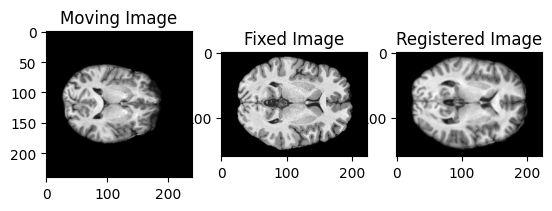

In [3]:
def reorient_image_to_match(reference_nii, target_nii):
    reference_ornt = nib.aff2axcodes(reference_nii.affine)
    target_reoriented = nib.as_closest_canonical(target_nii, enforce_diag=False)
    target_ornt = nib.aff2axcodes(target_reoriented.affine)
    
    # If orientations don't match, perform reorientation
    if target_ornt != reference_ornt:
        # Calculate the transformation matrix to match the reference orientation
        ornt_trans = nib.orientations.ornt_transform(nib.io_orientation(target_reoriented.affine),
                                                     nib.io_orientation(reference_nii.affine))
        target_reoriented = target_reoriented.as_reoriented(ornt_trans)
    return target_reoriented

def resampling(img_npy, img_pixdim, tar_pixdim, order, mode='constant'):
    if order == 0:
        img_npy = img_npy.astype(np.uint16)
    img_npy = zoom(img_npy, ((img_pixdim[0] / tar_pixdim[0]), (img_pixdim[1] / tar_pixdim[1]), (img_pixdim[2] / tar_pixdim[2])), order=order, prefilter=False, mode=mode)
    return img_npy

img_nib = reorient_image_to_match(template_nib, img_nib)
affine_type = 'Affine'
affine_metric = 'meanSquares'
tar_pixdim = [1.0, 1.0, 1.0]  # Target pixel dimensions
img_pixdim = img_nib.header.structarr['pixdim'][1:-4]

img_npy = img_nib.get_fdata()
img_npy = resampling(img_npy, img_pixdim, tar_pixdim, order=2)
img_torch = torch.from_numpy(img_npy[np.newaxis, np.newaxis, ...]).float().cuda(0)
template_npy = template_nib.get_fdata()
template_torch = torch.from_numpy(template_npy[np.newaxis, np.newaxis, ...]).float().cuda(0)

spatial_trans = SpatialTransformer(size=template_torch.shape[2:], mode='bilinear').cuda(0)
affine_model = AffineReg3D(vol_shape=template_torch.shape[2:], dof = "affine", scales = (0.5, 1.0), loss_funcs = ("mse", "mse"), ).cuda(0)
output = affine_model.optimize(img_torch, template_torch, steps_per_scale=(50, 50), verbose=True)
affine_flow = output['flow']
deformed = output['warped']
plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(img_torch[0, 0, :, :, img_torch.shape[4] // 2].detach().cpu().numpy(), cmap='gray')
plt.title('Moving Image')
plt.subplot(1, 3, 2)
plt.imshow(template_torch[0, 0, :, :, template_torch.shape[4] // 2].detach().cpu().numpy(), cmap='gray')
plt.title('Fixed Image')
plt.subplot(1, 3, 3)
plt.imshow(deformed[0, 0, :, :, deformed.shape[4] // 2].detach().cpu().numpy(), cmap='gray')
plt.title('Registered Image')
plt.show()

define deformable image registration model - we use VFA here in this example

In [4]:
H, W, D = template_npy.shape[0], template_npy.shape[1], template_npy.shape[2]
scale_factor = 1
config = CONFIGS_VFA.get_VFA_default_config()
config.img_size = (H//scale_factor, W//scale_factor, D//scale_factor)
print(config)
VFA_model = VFA(config, device='cuda:0')
pretrained_dir = 'pretrained_wts/'
pretrained_wts = 'VFA_LUMIR24.pth'
if not os.path.isdir("pretrained_wts/"):
    os.makedirs("pretrained_wts/")
if not os.path.isfile(pretrained_dir+pretrained_wts):
    # download model
    file_id = ModelWeights['VFA-LUMIR24-MonoModal']['wts']
    url = f"https://drive.google.com/uc?id={file_id}"
    gdown.download(url, pretrained_dir+pretrained_wts, quiet=False)

pretrained = torch.load(pretrained_dir+pretrained_wts)[ModelWeights['VFA-LUMIR24-MonoModal']['wts_key']]
VFA_model.load_state_dict(pretrained)
print('Pretrained Weights: {} loaded!'.format(pretrained_dir+pretrained_wts))
VFA_model.cuda()

affine: 0
downsamples: 4
img_size: !!python/tuple
- 160
- 224
- 192
in_channels: 1
initialize: 0.1
int_steps: 0
matching_channels: 8
max_channels: 64
name: VFA
skip: 0
start_channels: 8



Downloading...
From (original): https://drive.google.com/uc?id=17XEfRYJbnrtCVhaBCOvQVOLkWhix9PAK
From (redirected): https://drive.google.com/uc?id=17XEfRYJbnrtCVhaBCOvQVOLkWhix9PAK&confirm=t&uuid=1f31bda4-e0a9-4921-9ec4-1641051479d5
To: /scratch/jchen/python_projects/custom_packages/MIR/tutorials/brain_registration/pretrained_wts/VFA_LUMIR24.pth
100%|██████████| 32.4M/32.4M [00:02<00:00, 11.6MB/s]


Pretrained Weights: pretrained_wts/VFA_LUMIR24.pth loaded!


VFA(
  (encoder): Encoder(
    (encoder_conv): ModuleList(
      (0): DoubleConv3d(
        (conv1): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (norm1): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (conv2): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (norm2): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      )
      (1): DoubleConv3d(
        (conv1): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (norm1): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (conv2): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (norm2): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      )
      (2): DoubleConv3d(
        (conv1): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), paddin

begin deformable registration

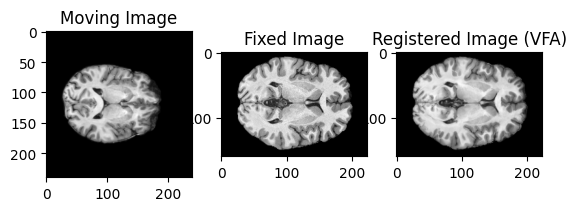

In [5]:
def normalize_image(img):
    img_min = torch.quantile(img, 0.01)
    img_max = torch.quantile(img, 0.99)
    img = (img - img_min) / (img_max - img_min)
    img = torch.clamp(img, 0.0, 1.0)
    return img

with torch.no_grad():
    deformed_ = normalize_image(deformed)
    template_torch_ = normalize_image(template_torch)
    deformable_flow = VFA_model((deformed_, template_torch_))
    flow = deformable_flow + spatial_trans(affine_flow, deformable_flow) # compose affine and deformable flows
    img_torch_padded = affine_model._pad_or_crop(img_torch, template_torch.shape[2:]) # pad or crop to match template size
    final_output = spatial_trans(img_torch_padded, flow)
plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(img_torch[0, 0, :, :, img_torch.shape[4] // 2].detach().cpu().numpy(), cmap='gray')
plt.title('Moving Image')
plt.subplot(1, 3, 2)
plt.imshow(template_torch[0, 0, :, :, template_torch.shape[4] // 2].detach().cpu().numpy(), cmap='gray')
plt.title('Fixed Image')
plt.subplot(1, 3, 3)
plt.imshow(final_output[0, 0, :, :, final_output.shape[4] // 2].detach().cpu().numpy(), cmap='gray')
plt.title('Registered Image (VFA)')
plt.show()

we can also use other models - TransMorphTVF

In [6]:
H, W, D = template_npy.shape[0], template_npy.shape[1], template_npy.shape[2]
scale_factor = 2
config = configs_TransMorph.get_3DTransMorph3Lvl_config()
config.img_size = (H//scale_factor, W//scale_factor, D//scale_factor)
config.window_size = (H // 64, W // 64, D // 64)
config.out_chan = 3
print(config)
TM_model = TransMorphTVF(config, time_steps=7)
pretrained_dir = 'pretrained_wts/'
pretrained_wts = 'TransMorphTVF_LUMIR24.pth.tar'
if not os.path.isfile(pretrained_dir+pretrained_wts):
    # download model
    file_id = ModelWeights['TransMorphTVF-LUMIR24-MonoModal']['wts']
    url = f"https://drive.google.com/uc?id={file_id}"
    gdown.download(url, pretrained_dir+pretrained_wts, quiet=False)

pretrained = torch.load(pretrained_dir+pretrained_wts)[ModelWeights['TransMorphTVF-LUMIR24-MonoModal']['wts_key']]
TM_model.load_state_dict(pretrained)
print('Pretrained Weights: {} loaded!'.format(pretrained_dir+pretrained_wts))
TM_model.cuda()

ape: false
depths: !!python/tuple
- 4
- 4
- 5
drop_path_rate: 0.3
drop_rate: 0
embed_dim: 96
if_convskip: true
if_transskip: true
img_size: !!python/tuple
- 80
- 112
- 96
in_chans: 2
mlp_ratio: 4
num_heads: !!python/tuple
- 8
- 8
- 8
out_chan: 3
out_indices: !!python/tuple
- 0
- 1
- 2
pat_merg_rf: 4
patch_norm: true
patch_size: 4
qkv_bias: false
reg_head_chan: 16
rpe: true
spe: false
use_checkpoint: false
window_size: !!python/tuple
- 2
- 3
- 3



Downloading...
From (original): https://drive.google.com/uc?id=1SSqI88l1MdrPJgE4Rn8pqXnVfZNPxtry
From (redirected): https://drive.google.com/uc?id=1SSqI88l1MdrPJgE4Rn8pqXnVfZNPxtry&confirm=t&uuid=7b517a94-250c-4576-aa88-d69e179d4eea
To: /scratch/jchen/python_projects/custom_packages/MIR/tutorials/brain_registration/pretrained_wts/TransMorphTVF_LUMIR24.pth.tar
100%|██████████| 372M/372M [00:32<00:00, 11.5MB/s] 


Pretrained Weights: pretrained_wts/TransMorphTVF_LUMIR24.pth.tar loaded!


TransMorphTVF(
  (transformer): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv3d(2, 96, kernel_size=(4, 4, 4), stride=(4, 4, 4))
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (pos_drop): Dropout(p=0, inplace=False)
    (layers): ModuleList(
      (0): BasicLayer(
        (blocks): ModuleList(
          (0): SwinTransformerBlock(
            (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=96, out_features=288, bias=False)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=96, out_features=96, bias=True)
              (proj_drop): Dropout(p=0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path): Identity()
            (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
            (mlp): Mlp(
              (fc1): Linear(in_features=96, out_features=38

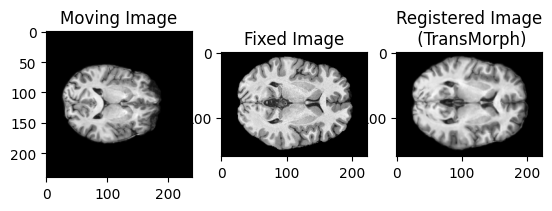

In [7]:
with torch.no_grad():
    deformed_ = normalize_image(deformed)
    template_torch_ = normalize_image(template_torch)
    deformed_ = F.avg_pool3d(deformed_, 2).cuda()
    template_torch_ = F.avg_pool3d(template_torch_, 2).cuda()
    deformable_flow = TM_model((deformed_, template_torch_))
    deformable_flow = F.interpolate(deformable_flow, size=template_torch.shape[2:], mode='trilinear', align_corners=True)
    flow = deformable_flow + spatial_trans(affine_flow, deformable_flow) # compose affine and deformable flows
    img_torch_padded = affine_model._pad_or_crop(img_torch, template_torch.shape[2:]) # pad or crop to match template size
    final_output = spatial_trans(img_torch_padded, flow)
plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(img_torch[0, 0, :, :, img_torch.shape[4] // 2].detach().cpu().numpy(), cmap='gray')
plt.title('Moving Image')
plt.subplot(1, 3, 2)
plt.imshow(template_torch[0, 0, :, :, template_torch.shape[4] // 2].detach().cpu().numpy(), cmap='gray')
plt.title('Fixed Image')
plt.subplot(1, 3, 3)
plt.imshow(final_output[0, 0, :, :, final_output.shape[4] // 2].detach().cpu().numpy(), cmap='gray')
plt.title('Registered Image\n (TransMorph)')
plt.show()

ConvexAdam-MIND

In [8]:
config = CONFIGS_CVXAdam.get_ConvexAdam_MIND_brain_default_config()
convexadam_model = convex_adam_MIND
print(config)

disp_hw: 2
grid_sp: 2
grid_sp_adam: 2
ic: true
lambda_weight: 1.6
mind_d: 2
mind_r: 1
path_fixed_mask: null
path_moving_mask: null
result_path: ./
selected_niter: 80
selected_smooth: 1
use_mask: false
verbose: false



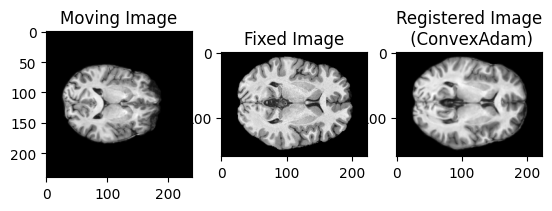

In [9]:
deformed_ = normalize_image(deformed)
template_torch_ = normalize_image(template_torch)
deformable_flow = convexadam_model(deformed_, template_torch_, config)
flow = deformable_flow + spatial_trans(affine_flow, deformable_flow) # compose affine and deformable flows
img_torch_padded = affine_model._pad_or_crop(img_torch, template_torch.shape[2:]) # pad or crop to match template size
final_output = spatial_trans(img_torch_padded, flow)
plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(img_torch[0, 0, :, :, img_torch.shape[4] // 2].detach().cpu().numpy(), cmap='gray')
plt.title('Moving Image')
plt.subplot(1, 3, 2)
plt.imshow(template_torch[0, 0, :, :, template_torch.shape[4] // 2].detach().cpu().numpy(), cmap='gray')
plt.title('Fixed Image')
plt.subplot(1, 3, 3)
plt.imshow(final_output[0, 0, :, :, final_output.shape[4] // 2].detach().cpu().numpy(), cmap='gray')
plt.title('Registered Image\n (ConvexAdam)')
plt.show()